# Comparing layers: a practical case on Mnist

In this tutorial, we compare the performance of different layers for mnist dataset


In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
#use_samples=256
use_samples=1024

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train=x_train[0:use_samples]
y_train=y_train[0:use_samples]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1024, 28, 28, 1)
1024 train samples
10000 test samples


In [3]:
from morpholayers import *
from morpholayers.layers import *
from morpholayers.constraints import *
from morpholayers.regularizers import *

In [4]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model

In [5]:
batch_size = 64 #128
epochs = 50


In [6]:
nfilterstolearn=8
filter_size=5
regularizer_parameter=.002

In [7]:
from sklearn.metrics import classification_report,confusion_matrix
def get_model(layer0):
    xin=Input(shape=input_shape)
    xlayer=layer0(xin)
    x=MaxPooling2D(pool_size=(2, 2))(xlayer)
    x=Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Flatten()(x)
    x=Dropout(0.5)(x)
    xoutput=Dense(num_classes, activation="softmax")(x)
    return Model(xin,outputs=xoutput), Model(xin,outputs=xlayer)

def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid('on')
    plt.legend()
    plt.show()
    plt.plot(history.history['accuracy'],label='acc')
    plt.plot(history.history['val_accuracy'],label='val_acc')
    plt.grid('on')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def plot_output_filters(model):
    fig=plt.figure()
    Z=model.predict(x_train[0:1,:,:,:])
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[0,:,:,i],cmap='gray',vmax=Z.max(),vmin=Z.min())
        #plt.colorbar()
    fig.suptitle('Output of Learned Filters for an example')

def plot_filters(model):
    Z=model.layers[-1].get_weights()[0]
    fig=plt.figure()
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[:,:,0,i],cmap='RdBu',vmax=Z.max(),vmin=Z.min())
    fig.suptitle('Learned Filters')
    
def see_results_layer(layer,lr=.001):
    modeli,modellayer=get_model(layer)
    modeli.summary()
    modeli.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(lr=lr), metrics=["accuracy"])
    historyi=modeli.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(patience=2,factor=.5)],verbose=0)
    Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
    y_pred = np.argmax(modeli.predict(x_test),axis=1)
    CM=confusion_matrix(Y_test, y_pred)
    print(CM)
    plt.imshow(CM,cmap='hot',vmin=0,vmax=1000)
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(Y_test, y_pred))
    plot_history(historyi)
    plot_filters(modellayer)
    plot_output_filters(modellayer)
    return historyi
    

## Example of Classical Convolutional Layer

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0     

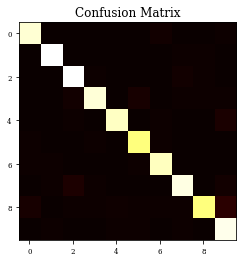

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.94      0.97      0.95      1032
           3       0.97      0.95      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.97      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.89      0.93       974
           9       0.91      0.97      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



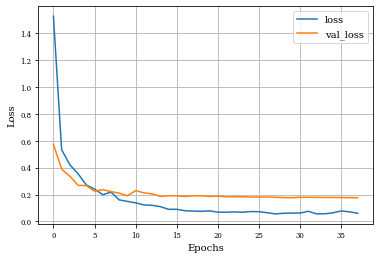

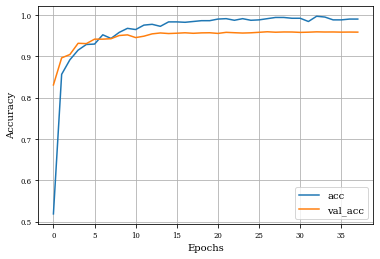

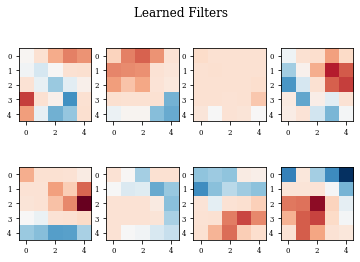

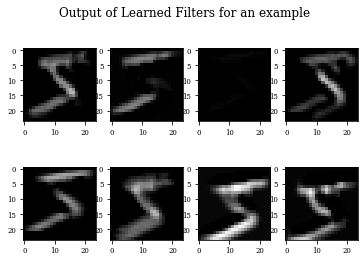

In [8]:
histConv=see_results_layer(Conv2D(nfilterstolearn, kernel_size=(filter_size, filter_size),
                                  kernel_regularizer=tensorflow.keras.regularizers.l1_l2(l1=regularizer_parameter,l2=regularizer_parameter), activation="relu"),lr=.01)

## Example of Dilation Layer

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
dilation2d (Dilation2D)      (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0   

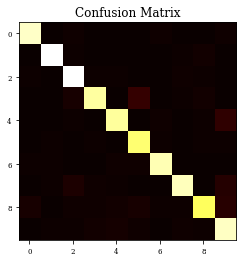

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.92      0.97      0.94      1032
           3       0.95      0.90      0.92      1010
           4       0.94      0.92      0.93       982
           5       0.89      0.96      0.92       892
           6       0.96      0.96      0.96       958
           7       0.96      0.91      0.93      1028
           8       0.94      0.86      0.90       974
           9       0.85      0.93      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000



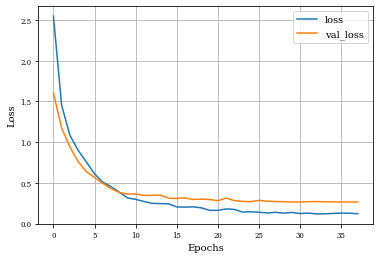

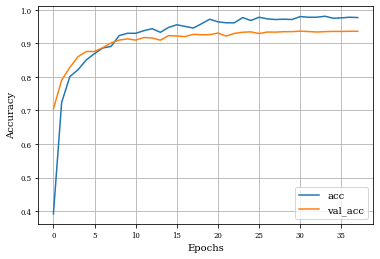

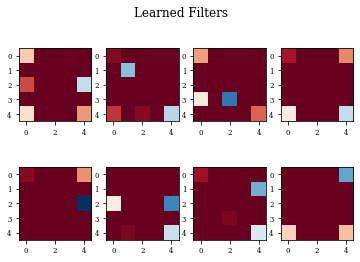

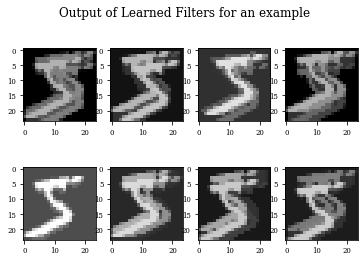

In [9]:
histDil=see_results_layer(Dilation2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Erosion Layer

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
erosion2d (Erosion2D)        (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0   

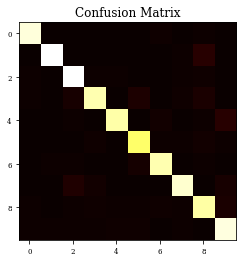

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.95      0.97      1135
           2       0.93      0.97      0.95      1032
           3       0.96      0.91      0.93      1010
           4       0.97      0.93      0.95       982
           5       0.94      0.95      0.94       892
           6       0.95      0.96      0.96       958
           7       0.96      0.93      0.94      1028
           8       0.89      0.93      0.91       974
           9       0.91      0.96      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



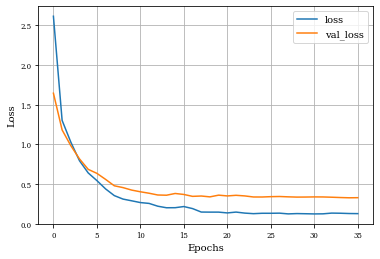

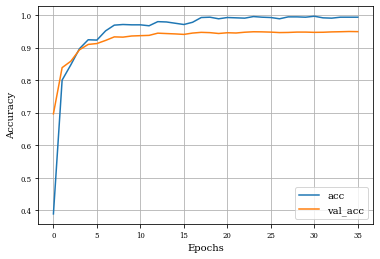

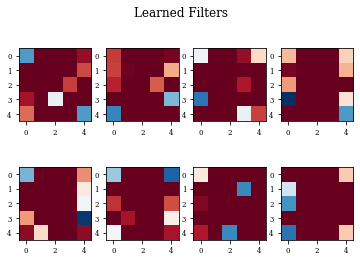

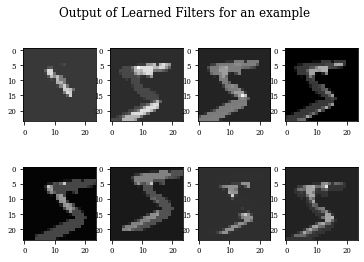

In [10]:
histEro=see_results_layer(Erosion2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Gradient Layer

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
gradient2d (Gradient2D)      (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 800)               0   

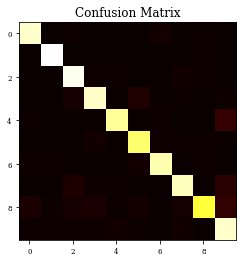

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.95      0.93      1032
           3       0.93      0.93      0.93      1010
           4       0.96      0.91      0.93       982
           5       0.92      0.96      0.94       892
           6       0.96      0.96      0.96       958
           7       0.94      0.91      0.92      1028
           8       0.96      0.82      0.89       974
           9       0.83      0.94      0.88      1009

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000



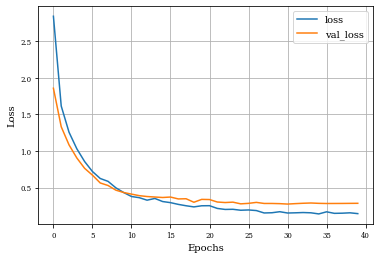

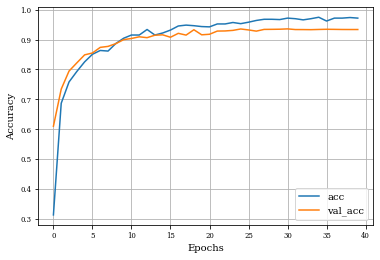

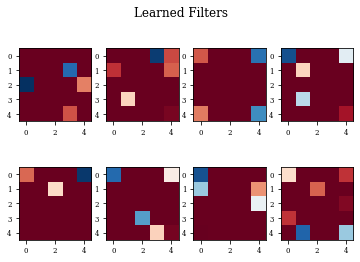

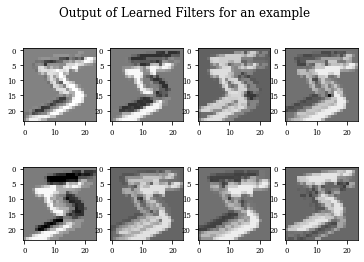

In [11]:
histGrad=see_results_layer(Gradient2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Internal Gradient Layer

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
internal_gradient2d (Interna (None, 28, 28, 8)         200       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        2336      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1152)              0   

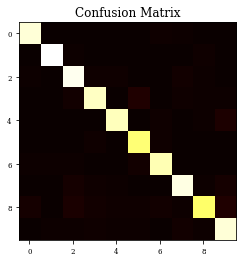

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.95      0.93      0.94      1010
           4       0.97      0.95      0.96       982
           5       0.93      0.97      0.95       892
           6       0.95      0.96      0.96       958
           7       0.95      0.94      0.94      1028
           8       0.95      0.87      0.91       974
           9       0.91      0.95      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



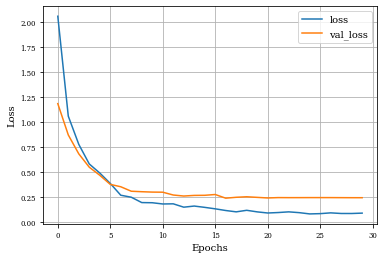

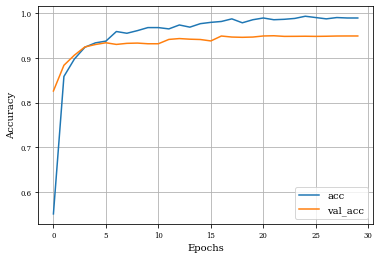

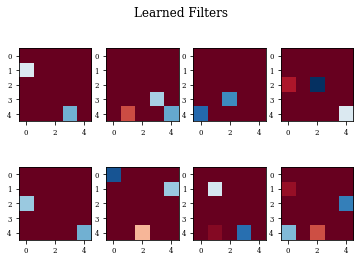

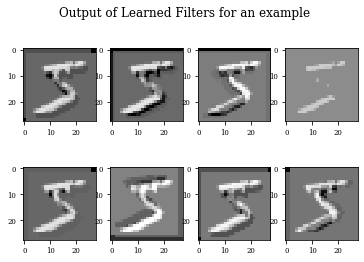

In [12]:
histInternalGrad=see_results_layer(InternalGradient2D(nfilterstolearn, padding='same',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Opening Layer

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
opening2d (Opening2D)        (None, 20, 20, 8)         200       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          2336      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0  

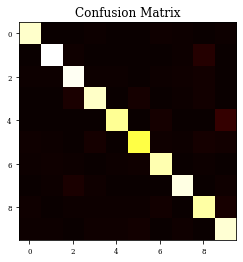

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.95      0.96      1135
           2       0.93      0.95      0.94      1032
           3       0.95      0.93      0.94      1010
           4       0.97      0.91      0.94       982
           5       0.95      0.91      0.93       892
           6       0.94      0.96      0.95       958
           7       0.96      0.95      0.95      1028
           8       0.90      0.93      0.92       974
           9       0.89      0.95      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



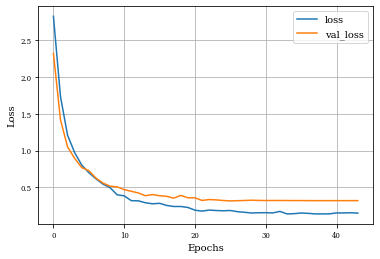

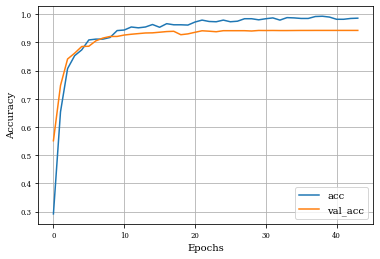

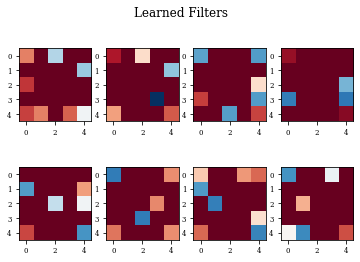

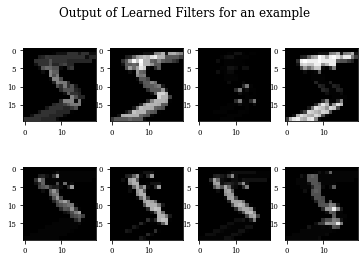

In [13]:
histOpening=see_results_layer(Opening2D(nfilterstolearn,padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Closing Layer

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
closing2d (Closing2D)        (None, 20, 20, 8)         200       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          2336      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0  

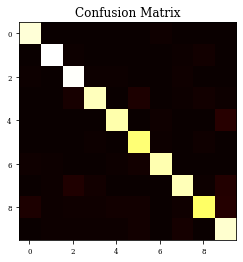

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.97      0.98      1135
           2       0.92      0.97      0.94      1032
           3       0.95      0.92      0.94      1010
           4       0.96      0.93      0.95       982
           5       0.92      0.97      0.94       892
           6       0.97      0.96      0.96       958
           7       0.95      0.90      0.92      1028
           8       0.94      0.87      0.90       974
           9       0.87      0.94      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



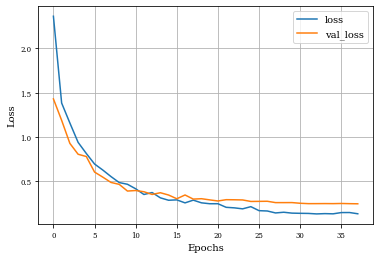

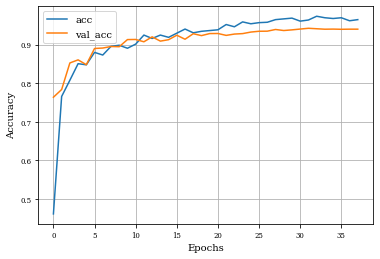

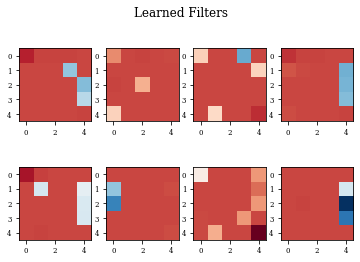

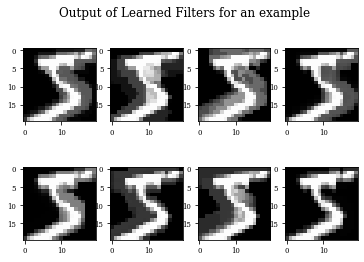

In [14]:
histClosing=see_results_layer(Closing2D(nfilterstolearn,padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Toggle Mapping Layer

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
toggle_mapping2d (ToggleMapp (None, 28, 28, 8)         200       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        2336      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1152)              0  

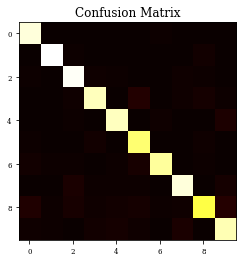

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.96      0.95      1032
           3       0.94      0.92      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.90      0.96      0.93       892
           6       0.97      0.94      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.93      0.84      0.88       974
           9       0.90      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



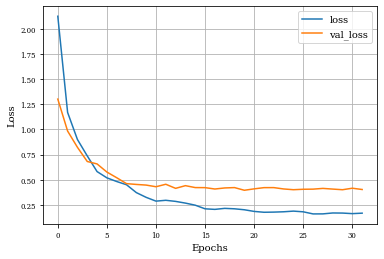

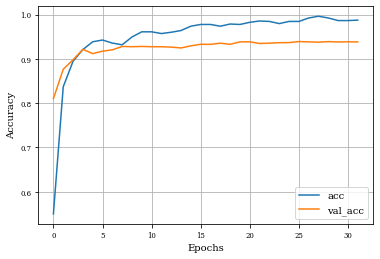

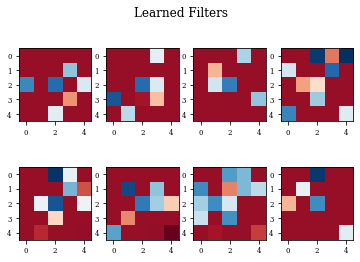

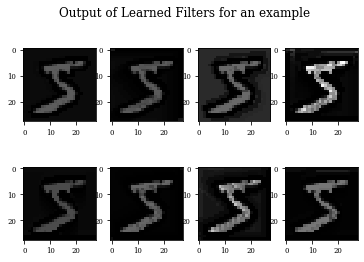

In [15]:
histToggle=see_results_layer(ToggleMapping2D(nfilterstolearn,kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Top Hat Opening Layer

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
top_hat_opening2d (TopHatOpe (None, 28, 28, 8)         200       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        2336      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1152)              0  

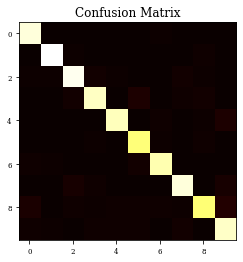

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.95      0.95      1032
           3       0.95      0.93      0.94      1010
           4       0.97      0.95      0.96       982
           5       0.93      0.97      0.95       892
           6       0.97      0.96      0.96       958
           7       0.95      0.94      0.94      1028
           8       0.95      0.88      0.91       974
           9       0.91      0.94      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



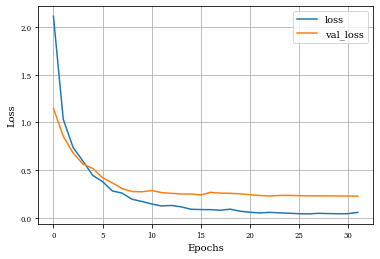

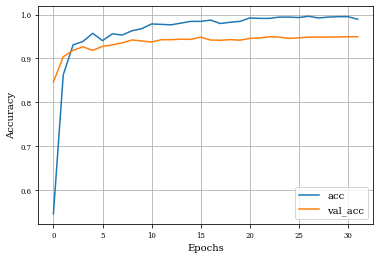

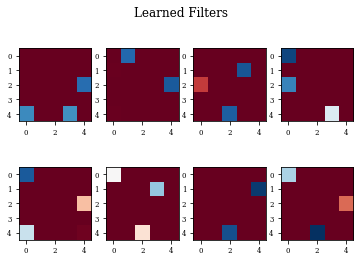

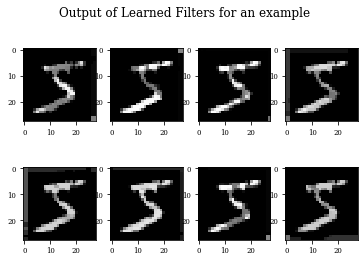

In [16]:
histTopHatOpening=see_results_layer(TopHatOpening2D(nfilterstolearn,kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Example of Top Hat Closing Layer

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
top_hat_closing2d (TopHatClo (None, 28, 28, 8)         200       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        2336      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1152)              0  

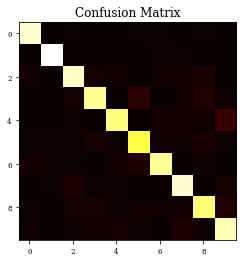

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.91      0.91      0.91      1032
           3       0.93      0.88      0.90      1010
           4       0.94      0.89      0.91       982
           5       0.89      0.91      0.90       892
           6       0.94      0.93      0.94       958
           7       0.92      0.93      0.93      1028
           8       0.89      0.88      0.89       974
           9       0.86      0.91      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



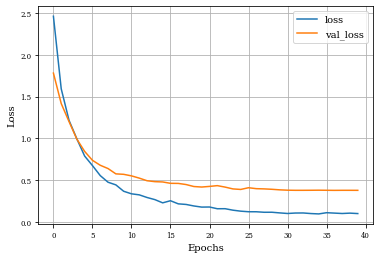

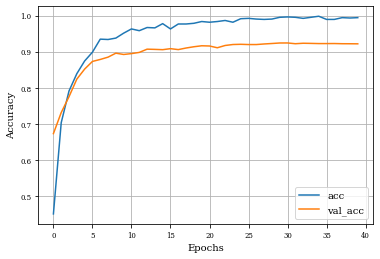

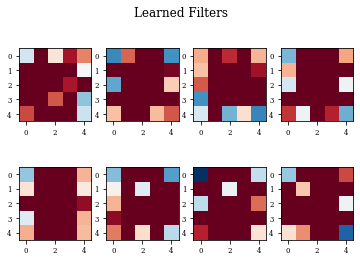

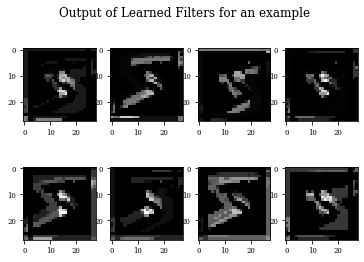

In [17]:
histTopHatClosing=see_results_layer(TopHatClosing2D(nfilterstolearn,kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

## Summary of Results
Best Results for method in training accurary:

In [18]:
print('Linear Convolution: ',max(histConv.history['accuracy']))
print('Dilation: ',max(histDil.history['accuracy']))
print('Erosion: ',max(histEro.history['accuracy']))
print('Gradient: ',max(histGrad.history['accuracy']))
print('Internal Gradient: ',max(histInternalGrad.history['accuracy']))
print('Toggle: ',max(histToggle.history['accuracy']))
print('TopHatOpening: ',max(histTopHatOpening.history['accuracy']))
print('TopHatClosing: ',max(histTopHatClosing.history['accuracy']))

Linear Convolution:  0.9970703125
Dilation:  0.98046875
Erosion:  0.99609375
Gradient:  0.974609375
Internal Gradient:  0.9931640625
Toggle:  0.99609375
TopHatOpening:  0.99609375
TopHatClosing:  0.998046875


Best Results for method in validation accurary:

In [19]:
print('Linear Convolution: ',max(histConv.history['val_accuracy']))
print('Dilation: ',max(histDil.history['val_accuracy']))
print('Erosin: ',max(histEro.history['val_accuracy']))
print('Gradient: ',max(histGrad.history['val_accuracy']))
print('Internal Gradient: ',max(histInternalGrad.history['val_accuracy']))
print('Toggle: ',max(histToggle.history['val_accuracy']))
print('TopHatOpening: ',max(histTopHatOpening.history['val_accuracy']))
print('TopHatClosing: ',max(histTopHatClosing.history['val_accuracy']))

Linear Convolution:  0.9595000147819519
Dilation:  0.9361000061035156
Erosin:  0.9491999745368958
Gradient:  0.9355999827384949
Internal Gradient:  0.9495000243186951
Toggle:  0.9388999938964844
TopHatOpening:  0.949400007724762
TopHatClosing:  0.9240000247955322


Comparison of Validaciones accuracy

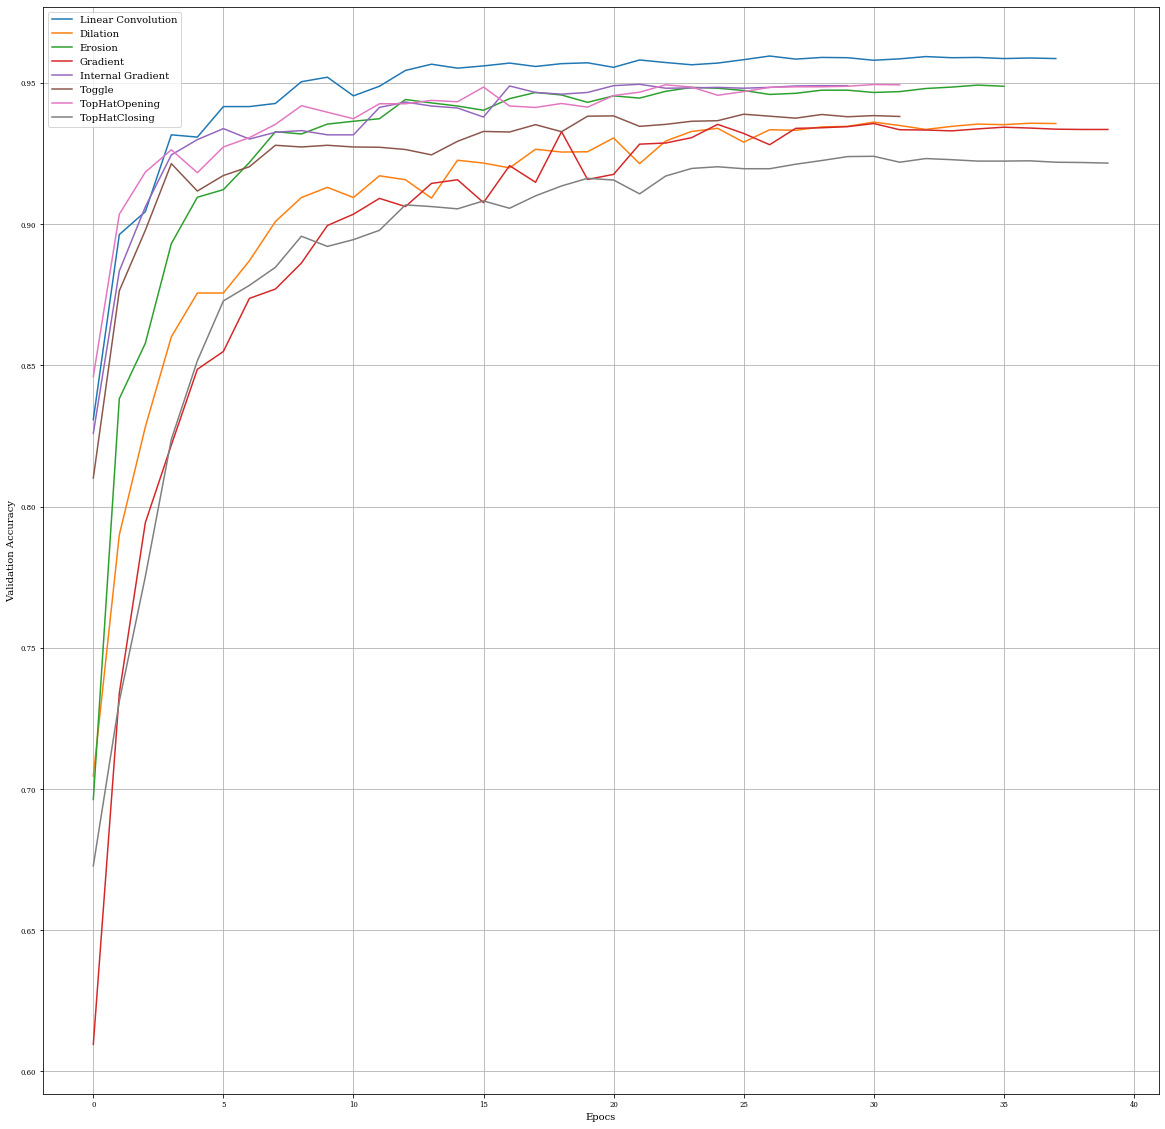

In [20]:
plt.figure(figsize=(20,20))
plt.plot(histConv.history['val_accuracy'],label='Linear Convolution')
plt.plot(histDil.history['val_accuracy'],label='Dilation')
plt.plot(histEro.history['val_accuracy'],label='Erosion')
plt.plot(histGrad.history['val_accuracy'],label='Gradient')
plt.plot(histInternalGrad.history['val_accuracy'],label='Internal Gradient')
plt.plot(histToggle.history['val_accuracy'],label='Toggle')
plt.plot(histTopHatOpening.history['val_accuracy'],label='TopHatOpening')
plt.plot(histTopHatClosing.history['val_accuracy'],label='TopHatClosing')
plt.xlabel('Epocs')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.legend()